### SS-VQE for the H2 molecule
Using Qiskit and Pyscf

In this notebook SS-VQE algorithm (Subspace-Search) VQE is implemented and used to find both the first excited state and the ground state of the $H_{2}$ molecule.

The results of SS-VQE are then compared to the classical solver of Pyscf, a lightweight, modular platform for quantum chemistry and solid-state calculations.

### Outline
<ol>
    <li>Required installs</li>
    <li>Algorithm steps</li>
    <li>Required imports</li>
    <li>Hamiltonian building and expectation values</li>
    <li>Ansatz and state preparation</li>
    <li>Weights and Gradients</li>
    <li>Running the soluition</li>
    <li>Conclusion</li>
    <li>References</li>
    <li>Versions</li>
</ol>

### Required installs
<hr>

The required installation steps are shown in the github Readme file also. If installed there then no need to reinstall here.

In [28]:
#!pip install qiskit['all']==1.4.4

In [29]:
#!pip install qiskit-nature-pyscf

In [30]:
#!pip install qiskit-aer

### Algorithm steps
<hr>

SS-VQE is an extension of VQE for finding excited states of a given Hamiltonian \( H \).

1. **State Preparation**  
   Prepare a set of \( k \) mutually orthogonal quantum states:
$|\phi_0\rangle, |\phi_1\rangle, \dots, |\phi_{k-1}\rangle$



2. **Parameterized Ansatz and Measurement**  
   For each \( i \), generate the variational state:
   $|\psi_i(\vec{\theta})\rangle = U(\vec{\theta}) |\phi_i\rangle$
   and measure the expectation value, $\langle \psi_i(\vec{\theta}) | H | \psi_i(\vec{\theta}) \rangle$ on quantum hardware.

3. **Cost Function Construction**  
   Sum the results with weights $( w_0 > w_1 > \dots > w_{k-1} > 0 )$, and compute the cost function on classical hardware:  
   $L(\vec{\theta}) = \sum_{i=0}^{k-1} w_i \langle \psi_i(\vec{\theta}) | H | \psi_i(\vec{\theta}) \rangle$


4. **Optimization**  
   Update the parameters $\vec{\theta}$ to minimize the cost function $L(\vec{\theta})$.

5. **Convergence**  
   Repeat steps 1–4 until convergence.

Once the minimum of $L(\vec{\theta})$ is reached at $\vec{\theta}'$, approximate eigenstates and eigenvalues of $ H $ are obtained as:  


$
|\psi_0(\vec{\theta}')\rangle, \dots, |\psi_{k-1}(\vec{\theta}')\rangle
$
  
and  

$
\langle \psi_0(\vec{\theta}') | H | \psi_0(\vec{\theta}') \rangle, \dots, \langle \psi_{k-1}(\vec{\theta}') | H | \psi_{k-1}(\vec{\theta}') \rangle
$

### Required imports
<hr>

In [31]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter, QuantumCircuit

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2

from pyscf import gto, scf
from pyscf import fci

import math, random
import numpy as np

The following cell is to get rid of warnings like deprecated qiskit versions, for example.

In [32]:
import warnings
warnings.filterwarnings('ignore')

### Hamiltonian building and expectation values
<hr>

The $H_{2}$ hamiltonian is shown in the pennylane VQE tutorial for this molecule in the first reference in the references section. It was just copied and built manually here using qiskit.

In [33]:
# Define your Hamiltonian as a list of (Pauli string, coefficient) pairs
H_list = [('IIII', -0.09963387941370971), ('ZIII', 0.17110545123720233), ('IZII', 0.17110545123720225), ('ZZII', 0.16859349595532533), ('YXXY', 0.04533062254573469), ('YYXX', -0.04533062254573469), ('XXYY', -0.04533062254573469), ('XYYX', 0.04533062254573469), ('IIZI', -0.22250914236600539), ('ZIZI', 0.12051027989546245), ('IIIZ', -0.22250914236600539), ('ZIIZ', 0.16584090244119712), ('IZZI', 0.16584090244119712), ('IZIZ', 0.12051027989546245), ('IIZZ', 0.1743207725924201)]
# Convert to SparsePauliOp
H2_op = SparsePauliOp.from_list(H_list)

In [34]:
H2_op

SparsePauliOp(['IIII', 'ZIII', 'IZII', 'ZZII', 'YXXY', 'YYXX', 'XXYY', 'XYYX', 'IIZI', 'ZIZI', 'IIIZ', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-0.09963388+0.j,  0.17110545+0.j,  0.17110545+0.j,  0.1685935 +0.j,
  0.04533062+0.j, -0.04533062+0.j, -0.04533062+0.j,  0.04533062+0.j,
 -0.22250914+0.j,  0.12051028+0.j, -0.22250914+0.j,  0.1658409 +0.j,
  0.1658409 +0.j,  0.12051028+0.j,  0.17432077+0.j])

A function that returns the expectation value of a circuit on an observable for given parameters.

In [35]:
def expectation(circuit, params, H):
  estimator = EstimatorV2()
  job = estimator.run(
      [
          (circuit, H, params)
      ],
      precision=0.0001
  )
  result = job.result()
  expectation_value = result[0].data.evs.real
  return expectation_value

### Ansatz and state preparation
<hr>

We define the ansatz as this one given in the following research paper.
https://ar5iv.labs.arxiv.org/html/1810.09434

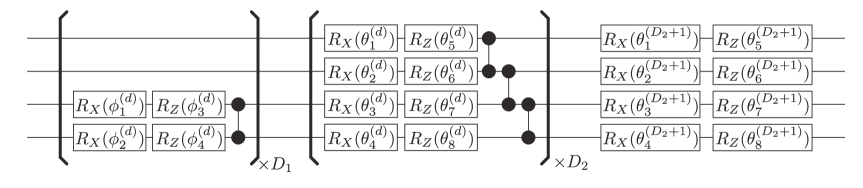

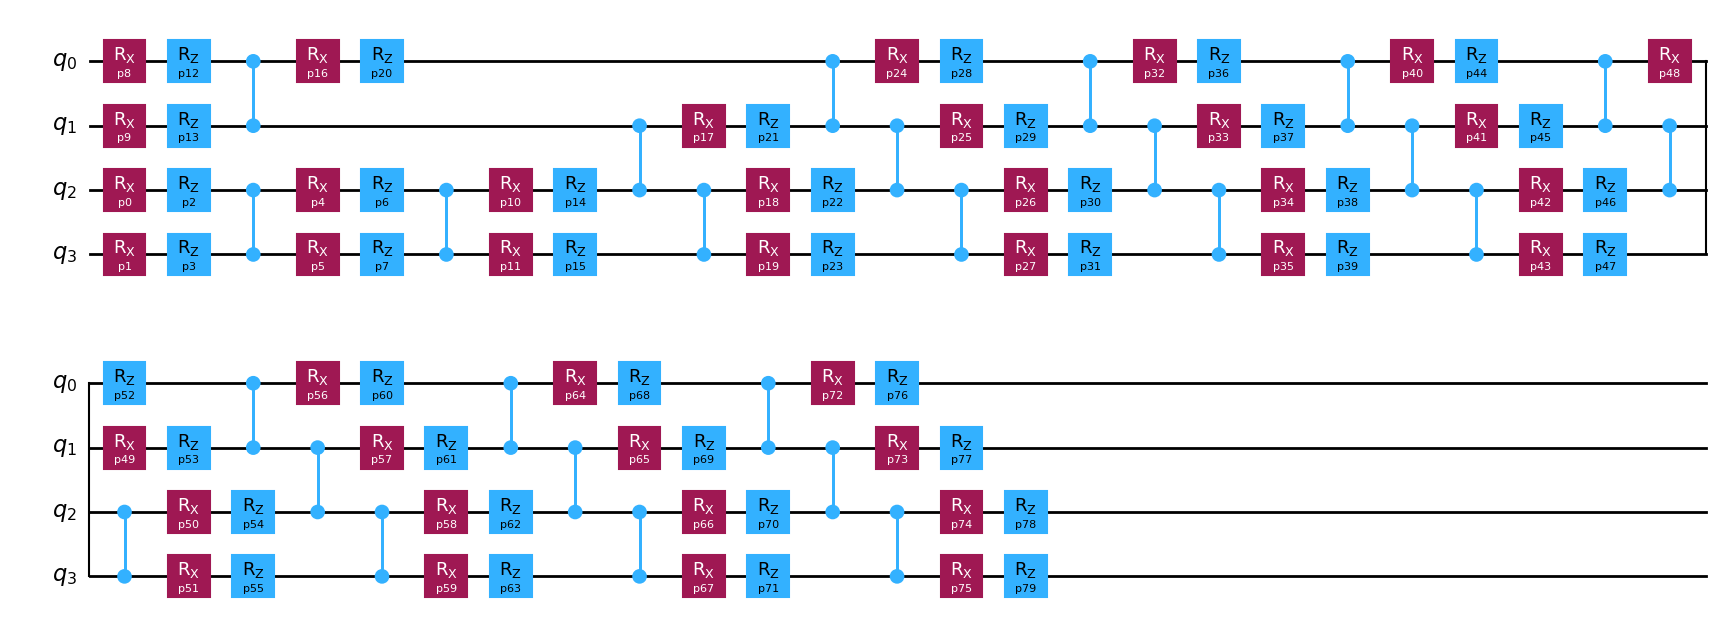

In [36]:
qc = QuantumCircuit(4)

D1 = 2
D2 = 8
num_p = 4*D1 + 8*D2 + 8

prs = [Parameter('p'+str(i)) for i in range(num_p)]

k = 0
for i in range(D1):
    qc.rx(prs[k], 2)
    k = k+1
    qc.rx(prs[k], 3)
    k = k+1

    qc.rz(prs[k], 2)
    k = k+1
    qc.rz(prs[k], 3)
    k = k+1

    qc.cz(2, 3)

for i in range(D2):
    qc.rx(prs[k], 0)
    k = k+1
    qc.rx(prs[k], 1)
    k = k+1
    qc.rx(prs[k], 2)
    k = k+1
    qc.rx(prs[k], 3)
    k = k+1

    qc.rz(prs[k], 0)
    k = k+1
    qc.rz(prs[k], 1)
    k = k+1
    qc.rz(prs[k], 2)
    k = k+1
    qc.rz(prs[k], 3)
    k = k+1



    qc.cz(0, 1)
    qc.cz(1, 2)
    qc.cz(2, 3)

qc.rx(prs[k], 0)
k = k+1
qc.rx(prs[k], 1)
k = k+1
qc.rx(prs[k], 2)
k = k+1
qc.rx(prs[k], 3)
k = k+1

qc.rz(prs[k], 0)
k = k+1
qc.rz(prs[k], 1)
k = k+1
qc.rz(prs[k], 2)
k = k+1
qc.rz(prs[k], 3)
k = k+1

qc.draw('mpl')

By adding an X gate to first qubit, the input state is the first excited state |0001> instead of the ground state |0000>. By this way, the initial states are prepared. Worth mentioning that the states should be orthogonal and this is the case for |0000> and |0001>.

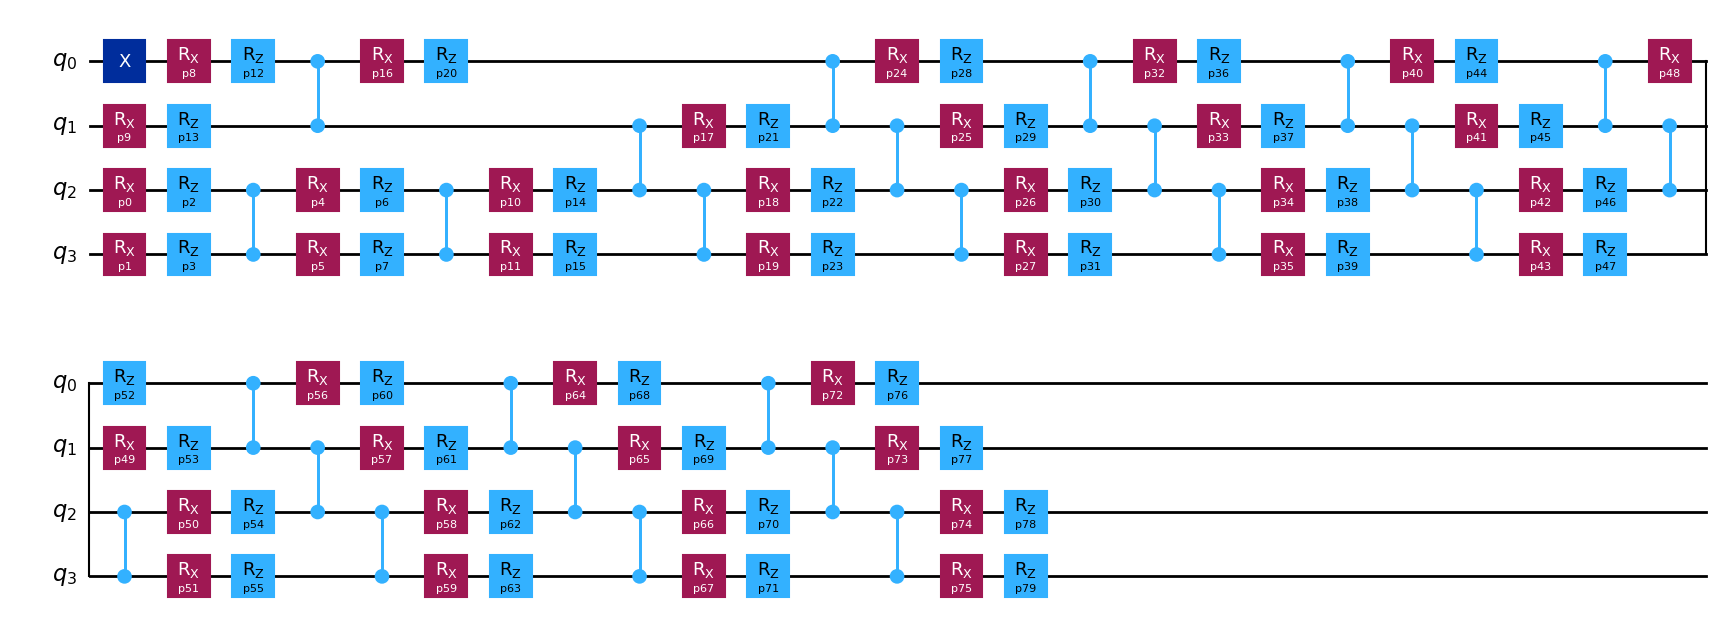

In [37]:
qc2 = QuantumCircuit(4)
qc2.x(0)
qc2 = qc2.compose(qc)
qc2.draw('mpl')

### Weights and gradients
<hr>

We define 2 weights to use with SSVQE. By other words we are using Weighted-SSVQE.

In [38]:
w = np.arange(4, 2, -1)
w

array([4, 3])

The following list contains 2 circuits, first with input |0000> and the second with input |0001>.

In [39]:
qcs = [qc, qc2]

We calculate the gradients using the parameter shift rule for pauli operators. Calculating the gradients is used to update the parameters of the circuit.
$\nabla_{\theta}f(x; \theta) = \tfrac{1}{2}\left[ f(x; \theta + \tfrac{\pi}{2}) - f(x; \theta - \tfrac{\pi}{2}) \right]$.
Where f(x) is the expectation value of the circuit on the observable for specific parameters.

In [40]:
def gradient(qcs, H, w, num_qubits, parameters):
    gradients = np.zeros((len(parameters), ))
    cost = 0
    parameters = list(parameters)
    for i in range(num_qubits-2):
        for j in range(len(parameters)):
            parameters1 = parameters[:]
            parameters1[j] += +np.pi/2
            parameters2 = parameters[:]
            parameters2[j] += -np.pi/2
            term = w[i]*0.5*(expectation(qcs[i], parameters1, H) - expectation(qcs[i], parameters2, H))
            gradients[j] += term
        cost += w[i]*expectation(qcs[i], parameters, H)
    return gradients, cost

The following is the implementation of the Adam optimizer from scratch. It uses the previously calculated gradients to update the parameters at each iteration.

In [41]:
def adam(qcs, n_iter, alpha, beta1, beta2, H, w, num_qubits, combined, eps=1e-8):
	# generate an initial point
	# Parameters
    mean = 0
    std_dev = 2*np.pi
    num_samples = len(list(qcs[0].parameters))
    score0 = 10

    # Generate samples
    x = np.array([float(random.gauss(mean, std_dev)) for _ in range(num_samples)], dtype=np.float32)
	# initialize first and second moments
    m = [0.0 for _ in range(x.shape[0])]
    v = [0.0 for _ in range(x.shape[0])]
	# run the gradient descent updates
    for t in range(n_iter):
		# calculate gradient g(t)
        qcs2 = qcs[:]
        g, score = gradient(qcs2, H, w, num_qubits, x)
		# build a solution one variable at a time
        for i in range(x.shape[0]):
			# m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
			# v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
			# mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
			# vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
			# x(t) = x(t-1) - alpha * mhat(t) / sqrt(vhat(t)) + eps
            x[i] = x[i] - alpha * mhat / (math.sqrt(vhat) + eps)
		# report progress
        print('>%d score = %.5f' % (t, score))
        combined.append((t, x, score))
    return [x, score]

### Running the solution
<hr>

We run now SSVQE to find the ground and excited states of $H_{2}$.

In [42]:
combined = []
# define the total iterations
max_n_iter = 30
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.9
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam(qcs = qcs, n_iter=max_n_iter, alpha=alpha, beta1=beta1, beta2=beta2, H=H2_op, w=w, num_qubits=4, combined=combined, eps=1e-8)
print('Done!')
print('f(%s) = %f' % (best, score))

>0 score = 0.68223
>1 score = -1.76989
>2 score = -2.53963
>3 score = -2.83915
>4 score = -3.36916
>5 score = -4.06734
>6 score = -4.49071
>7 score = -4.57709
>8 score = -4.79609
>9 score = -5.06195
>10 score = -5.20537
>11 score = -5.31244
>12 score = -5.42988
>13 score = -5.49157
>14 score = -5.52485
>15 score = -5.57295
>16 score = -5.60492
>17 score = -5.61693
>18 score = -5.62897
>19 score = -5.66152
>20 score = -5.70856
>21 score = -5.72105
>22 score = -5.69284
>23 score = -5.68516
>24 score = -5.72728
>25 score = -5.76887
>26 score = -5.76624
>27 score = -5.74164
>28 score = -5.74133
>29 score = -5.77254
Done!
f([  6.3058686   -1.9830405    1.2565747    3.6184676   -1.9054308
   0.9384284   -1.7771713   -7.5159435    3.0195758    6.262115
  -4.334619     2.779545    13.581716    -2.0536573    6.2612047
   0.16358788 -13.3352995    2.0677931    1.9873519  -15.186793
   1.5512444   -6.826147   -10.175863     2.8516953   16.859188
   5.285254     9.396482    -0.11568802  -1.0178736

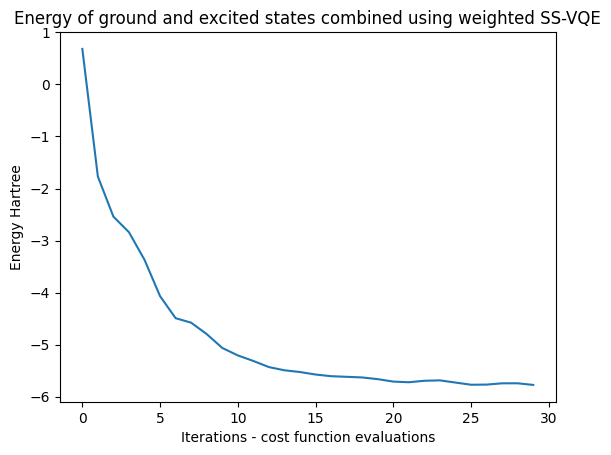

In [43]:
energies = [combined[i][2] for i in range(len(combined))]

import matplotlib.pyplot as plt
plt.plot(list(range(len(combined))), energies)
plt.title("Energy of ground and excited states combined using weighted SS-VQE")
plt.xlabel("Iterations - cost function evaluations")
plt.ylabel("Energy Hartree")
plt.show()

In [44]:
best=combined[-1][1]

In [45]:
print("The ground state energy of H2 is ", expectation(qcs[0], best, H2_op))

The ground state energy of H2 is  -1.1205288473358201


In [46]:
print("The excited state energy of H2 is ", expectation(qcs[1], best, H2_op))

The excited state energy of H2 is  -0.4424497024857199


### Classical solution using pyscf:
<hr>

It is important to mention that to build a molecule we specify the (x, y, z) coordinates for each atom in the molecule. These values can be found online and not calculated manually. And these values are variable and can change leading to different energies.

The values of the coordinates used to build the atom here are the same for that used for building the hamiltonian used for SS-VQE.

In [47]:
# Define H2 molecule
mol = gto.M(
    atom="H 0.0, 0.0, -0.6614; H 0.0, 0.0, 0.6614",
    basis="sto-3g",
    spin=0,
    charge=0
)

# Run Hartree-Fock
mf = scf.RHF(mol)
mf.kernel()

# Instantiate the FCI solver
fci_solver = fci.FCI(mf)

# Run Full CI (FCI)
fci_energies, _ = fci_solver.kernel(nroots=5)

print("🔬 FCI Energies (Hartree):")
for i, e in enumerate(fci_energies):
    print(f"  State {i}: {e:.6f}")

converged SCF energy = -0.965839207860032
🔬 FCI Energies (Hartree):
  State 0: -1.030503
  State 1: -0.860358
  State 2: -0.424502
  State 3: -0.231386


### Conclusion:
<hr>

In this notebook we have shown the following:
<ol>
    <li>How to build the hamiltonian operator of a molecule.</li>
    <li>How to calculate the gradients of a quantum circuit and use an optimizer with the circuit.</li>
    <li>How to implement SSVQE for calculating the ground and first excited states energy.</li>
</ol>

\begin{array}{|c|c|c|}
\hline
\textbf{Algorithm} & \textbf{ground state energy} & \textbf{1st excited energy}\\
\hline
\text{SS-VQE} & {-1.12} & -0.44\\
\text{Pyscf} & {-1.03} & -0.86\\
\hline
\end{array}

Although the energy of the ground state was near to that calculated by Pyscf but that of the first excited state was not. It is worth mentioning that such accuracy depends on many factors like ansatz used, optimizer, number of layers in the ansatz, weights, etc.

So we cannot yet conclude that SS-VQE is not an accurate algorithm but for these specifications used in this notebook it was not accurate especially for the first excited state.

### References
<hr>

<ol>
    <li>Pennylane VQE tutorial and H2 hamiltonian: <a href="https://pennylane.ai/qml/demos/tutorial_vqe">link</a></li>
    <li>Qiskit VQE: <a href="https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html">link</a></li>
    <li>Algorithms for finding ground and excited states: <a href="https://quantaggle.com/algorithms/algorithm/">link</a></li>
    <li>Pennylane parameter shift: <a href="https://pennylane.ai/qml/glossary/parameter_shift">link</a></li>
    <li>Python adam optimizer from scratch: <a href="https://www.geeksforgeeks.org/how-to-implement-adam-gradient-descent-from-scratch-using-python/">link</a></li>    
</ol>

### Versions
<hr>

In [48]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [49]:
import pkg_resources

# Loop through installed packages and filter those starting with 'qiskit'
for dist in pkg_resources.working_set:
    if dist.project_name.lower().startswith("qiskit"):
        print(f"{dist.project_name} == {dist.version}")

qiskit == 1.4.4
qiskit-aer == 0.17.1
qiskit-algorithms == 0.4.0
qiskit-nature == 0.7.2
qiskit-nature-pyscf == 0.4.0
qiskit-qasm3-import == 0.6.0
